In [1]:
import pandas as pd
from preprocess import Audio_Processor
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
from sklearn.neighbors import KNeighborsClassifier as KNN

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="2"

SR = 16000
blocksize = int(SR*5)
overlap = 0

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')

In [5]:
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }
dataset['h_target'] = None
classes = [None] * 50
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

In [6]:
h_classes = ['Human & Animal', 'Interacting Materials']

## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [7]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=None, 
                        blocksize=blocksize, 
                        overlap=overlap)

In [8]:
df.describe()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2.000000e+03,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,53.435557,32.229973,27.239386,23.687849,21.480062,21.292745,20.731369,20.751350,20.478451,20.043954,...,-2.107854e-02,-2.168583e-02,26.980379,41.087010,10.167191,37.006145,2.946109,0.620000,24.500000,3.000000
std,39.223824,21.287547,20.558804,17.868727,17.542057,17.855402,17.637597,18.043416,18.065087,17.638089,...,2.943802e-02,2.916666e-02,120.497045,117.515687,37.760749,34.845984,3.189635,0.485508,14.434479,1.414567
min,0.050693,0.059624,0.047621,0.080312,0.061050,0.086123,0.053342,0.058926,0.039076,0.032498,...,-1.666826e-01,-1.753639e-01,6.002570,11.716387,1.302239,9.002370,0.160746,0.000000,0.000000,1.000000
25%,20.110392,13.696971,10.067995,8.849415,7.243266,6.958336,6.656088,6.436401,6.277766,6.054820,...,-4.144534e-02,-4.185786e-02,10.795127,21.272453,4.017424,17.355580,0.810786,0.000000,12.000000,2.000000
50%,34.766516,23.761097,16.147402,13.026436,10.001338,9.551854,9.062050,8.918661,8.792426,8.619720,...,-1.963705e-02,-2.086153e-02,21.429574,33.332287,7.368222,29.093507,2.175887,1.000000,24.500000,3.000000
75%,88.401117,50.136865,44.498308,40.677591,38.821554,39.292735,38.852329,39.194125,38.194944,37.908485,...,-7.689589e-10,-5.289343e-10,32.460250,47.865920,12.050406,47.472269,3.996936,1.000000,37.000000,4.000000
max,202.348903,113.774744,93.795679,78.764452,75.227919,79.348655,83.762159,96.108132,107.393085,105.205714,...,6.350198e-02,6.030374e-02,5354.346238,5121.291695,1652.871867,919.807129,49.084584,1.000000,49.000000,5.000000


In [9]:
from sklearn.model_selection import train_test_split
train, test, = train_test_split(
                        df[df.fold != 1], test_size=0.20, random_state=42)

In [10]:
from sklearn.preprocessing import normalize

train_X = train.drop(['target', 'h_target', 'fold'], axis=1)
train_y = train['h_target']
test_X = test.drop(['target', 'h_target', 'fold'], axis=1)
test_y = test['h_target']

# KNN Grid Search

In [11]:
from sklearn.model_selection import GridSearchCV
params = {
          'n_neighbors': range(5,25,1),
          'algorithm': ('ball_tree', 'kd_tree', 'brute')
         }

knn = KNN(n_neighbors=15, algorithm='ball_tree')

clf = GridSearchCV(knn, params, cv=5)

clf.fit(train_X, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': range(5, 25), 'algorithm': ('ball_tree', 'kd_tree', 'brute')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [12]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_algorithm',
 'param_n_neighbors',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

0.675
Confusion matrix, without normalization
[[ 58  68]
 [ 36 158]]


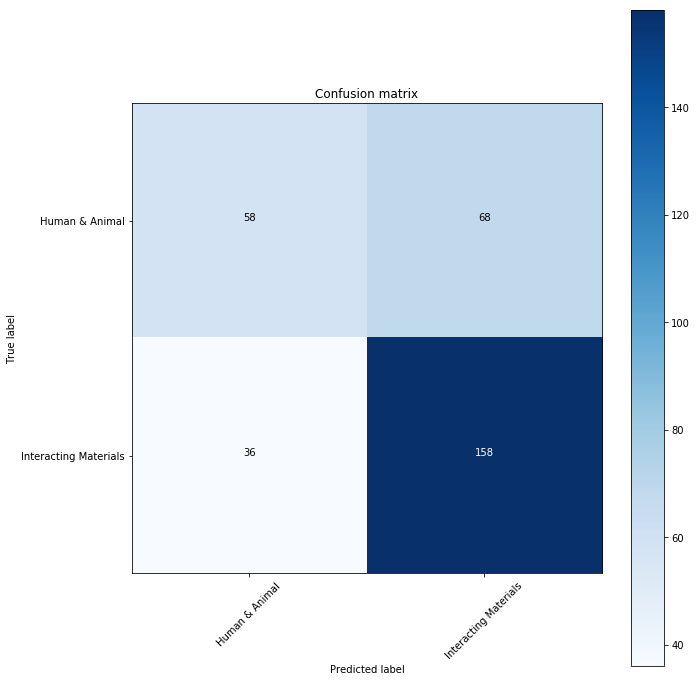

In [13]:
pred = clf.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# All Data

In [14]:
all_df = df[df.fold == 1]

In [15]:
X = all_df.drop(['target', 'h_target', 'fold'], axis=1)
y = all_df['h_target']

0.64
Confusion matrix, without normalization
[[ 65  87]
 [ 57 191]]


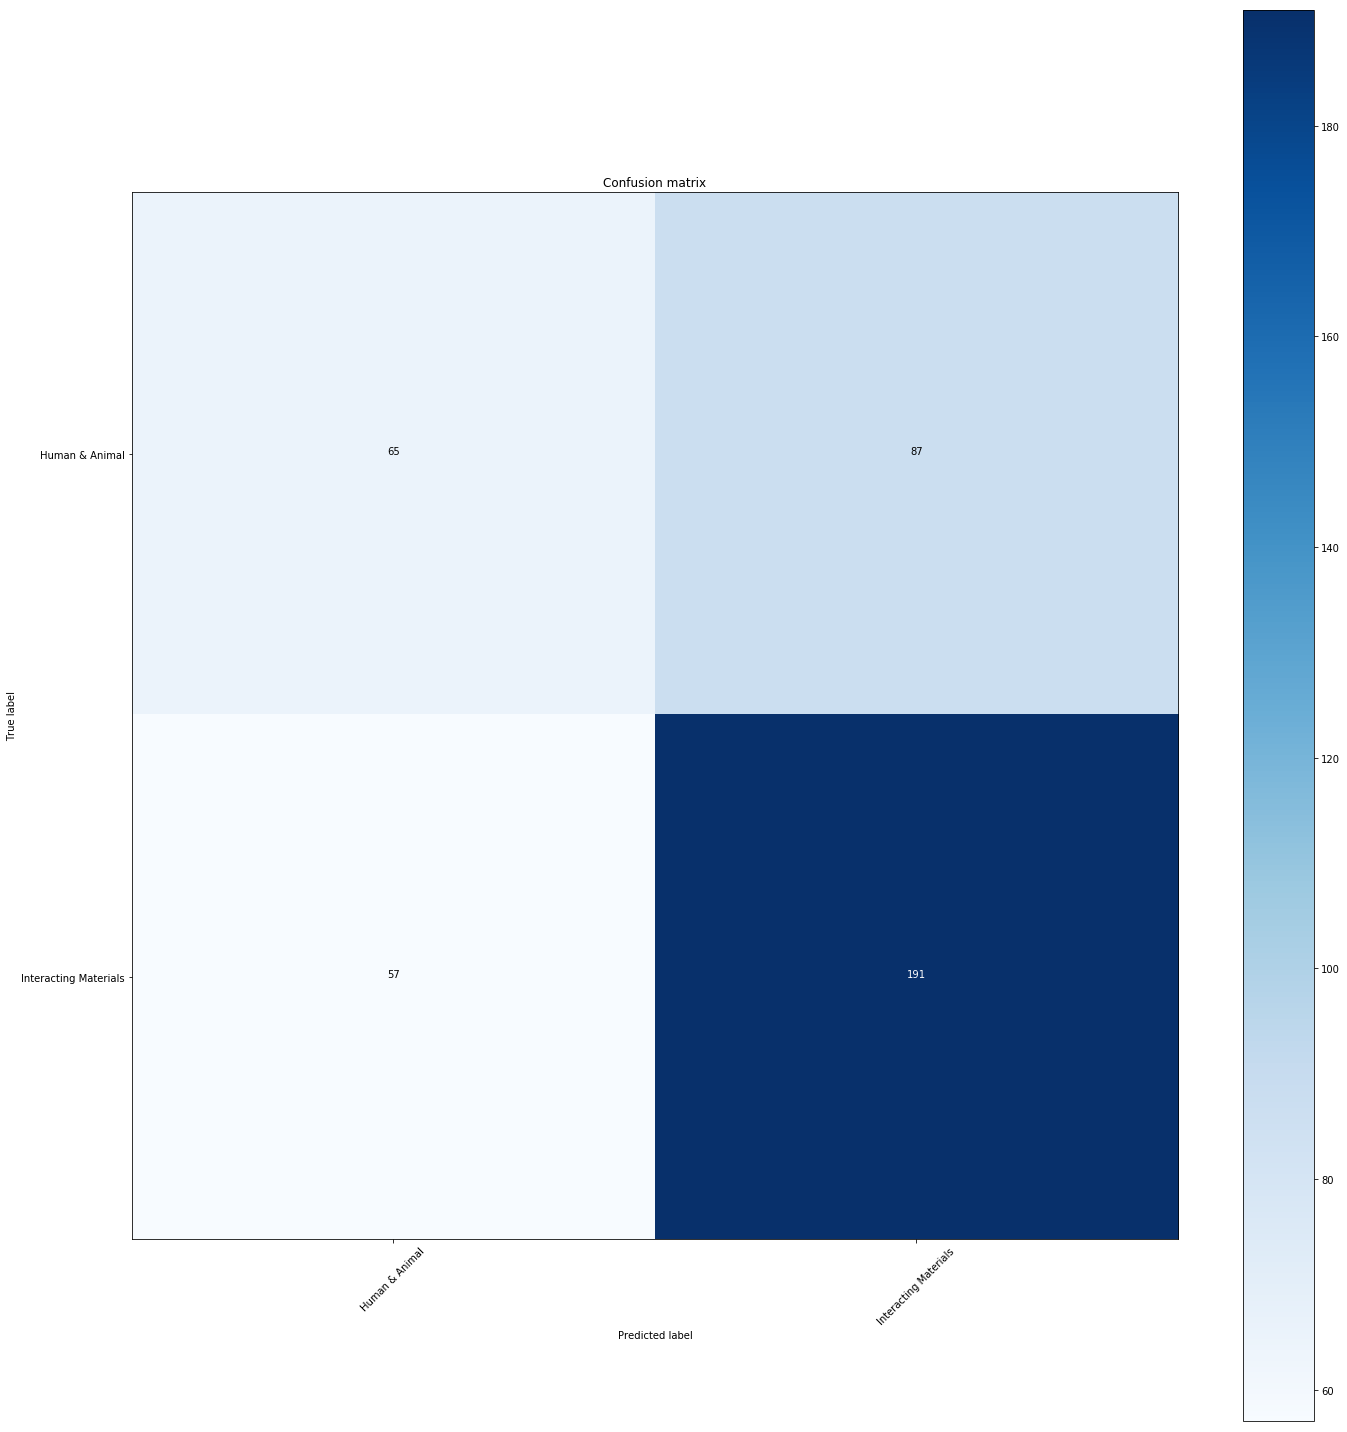

In [16]:
pred = clf.predict(X)
pred_prob = clf.predict_proba(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [17]:
clf.best_estimator_ 

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=23, p=2,
           weights='uniform')

In [18]:
import seaborn as sns
misclassified = {
    'h_target': [],
    'target': [],
    'prob_0': [],
    'prob_1': []
}
for row, p, prob, Y in zip(all_df.iterrows(), pred, pred_prob, y):
    Y = int(Y)
    p = int(p)
    if p!=Y:
        misclassified['target'].append(classes[int(row[1]['target'])])
        misclassified['h_target'].append(h_classes[p])
        misclassified['prob_0'].append(prob[0])
        misclassified['prob_1'].append(prob[1])

misclassified = pd.DataFrame.from_dict(misclassified)
misclassified.head()

,h_target,prob_0,prob_1,target
0,Interacting Materials,0.217391,0.782609,chirping_birds
1,Human & Animal,0.695652,0.304348,can_opening
2,Interacting Materials,0.304348,0.695652,crow
3,Interacting Materials,0.391304,0.608696,clapping
4,Interacting Materials,0.086957,0.913043,clapping


In [19]:
average_prob = misclassified.groupby('h_target').mean()
average_prob.head()

,prob_0,prob_1
h_target,,
Human & Animal,0.614798,0.385202
Interacting Materials,0.297351,0.702649


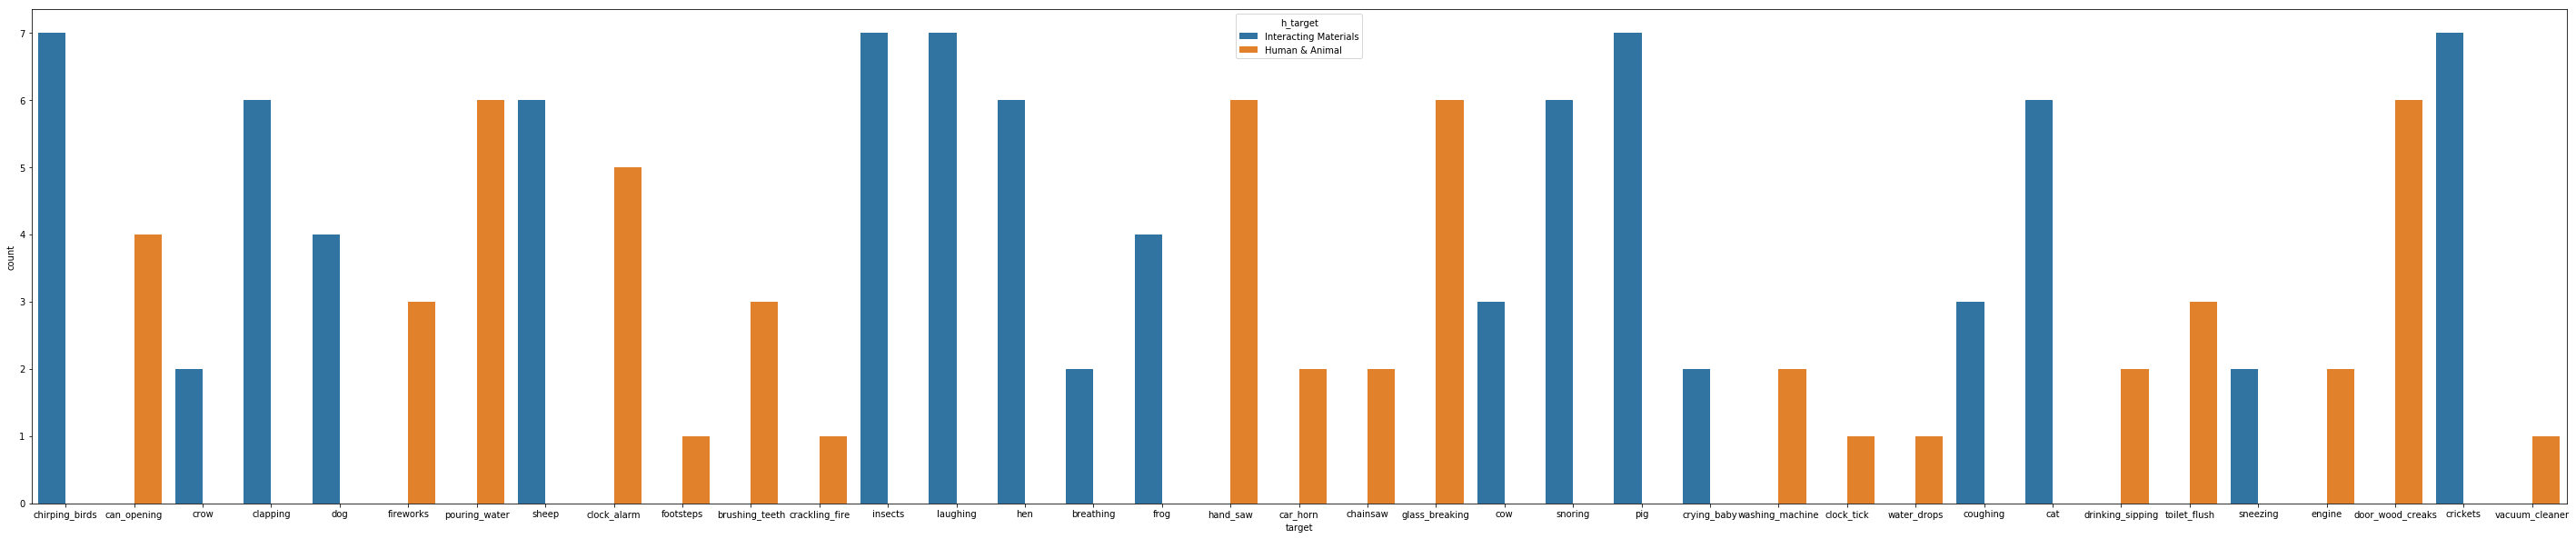

In [20]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(50,10))
sns.countplot(x='target', hue='h_target',data=misclassified)